<a href="https://colab.research.google.com/github/bene58/Projeto-2-VisaoComp/blob/main/Code_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Google Drive
---

* If you are running on Google Colab, don't forget to enable GPU access.
    * Edit >> Laptop Settings >> Hardware Accelerator
    * Select GPU
    * OK
* After use, disable access.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


## Importing the required libraries
---


In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

## Settings for reproducibility
---
* Convolutional Neural Network (CNN) operations often rely on random numbers.
* When repeating an experiment multiple times, the results may exhibit slight variations, even when using the same data, models, and hyperparameters.
* To ensure reproducibility across different experiment runs, it is often beneficial to set fixed seeds for the random number generators.

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---


In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Fri Dec 27 15:18:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData'
else:
    ### ds_path = 'data/flowers-recognition/flowers/'
    ds_path = '/content/drive/MyDrive/Projeto2_visaoComp/'

## Setting up the experiment folder
---

In [ ]:
EXP_PATH = './exp-lec6_p3_01/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

## Setting hyperparameters and configurations
---

In [ ]:
# Batch size (mini-batch size)
batch_size = 64
# Learning rate
lr = 0.0001
# Mommentum
mm = 0.9
# Number of training epochs
epochs = 50 # Use a small value during development, 2 for example.
# Step size - For the learning rate scheduler (StepLR).
ss = 10

In [ ]:
# Select the network architecture.
ARCH_NAME = 'efficientnet' # 'simplenet', 'alexnet', 'resnet18', ...
# Note: 'simplenet' refers to the architecture we developed.
# For information on additional architectures, please refer to the torchvision documentation: https://pytorch.org/vision/stable/models.html.

## Preparing the dataset
---

### Customized Dataset class

In [ ]:
class FlowersDataset(Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        path = self.path_list[idx]
        ### image = io.imread(self.path_list[idx])
        image = Image.open(self.path_list[idx])

        label = self.label_list[idx]

        if self.transforms:
            image = self.transforms(image)

        return (image, label, path)

### Data transforms

In [ ]:
# Training. With data augmentation
data_transforms_train = transforms.Compose([# DATA AUGMENTATION
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomRotation(degrees=15),
                                            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                            transforms.GaussianBlur(kernel_size=3),
                                            # Resizes images to the size of the network input.
                                            ### transforms.Resize(size=(224, 224)),
                                            transforms.RandomResizedCrop(size=224),
                                            transforms.ToTensor(),
                                            # Normalization. ImageNet mean and standard deviation.
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ])

data_transforms_val = transforms.Compose([# Resizes images to the size of the network input.
                                          ### transforms.Resize(size=(224, 224)),
                                          transforms.RandomResizedCrop(size=224),
                                          transforms.ToTensor(),
                                          # Normalization. ImageNet mean and standard deviation.
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])

data_transforms_test = transforms.Compose([# Resizes images to the size of the network input.
                                           ### transforms.Resize(size=(224, 224)),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           # Normalization. ImageNet mean and standard deviation.
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])

### Process the dataset file tree

In [ ]:
# Class names
# ---
# Do not ensure that only folders are retrieved.
### class_names = os.listdir(ds_path)
# Ensure that only folders are retrieved.
class_names = [item for item in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, item))]
print(class_names)
# Sort the class names
class_names.sort()

# Number of classes. Corresponds to the number of subfolders in the dataset folder.
num_classes = len(class_names)

['fire_images', 'non_fire_images']


In [ ]:
# List with all paths to images and their respective labels
path_list = []
label_list = []

# Iterate through the class folders
for class_ in class_names:
    # Ordered list of files (images) in each folder
    path_list_ = os.listdir(os.path.join(ds_path, class_))
    path_list_.sort()

    # Iterates through the files in the current folder (class)
    for path_image in path_list_:
        file_path = os.path.join(ds_path, class_, path_image)
        path_list.append(file_path)
        label_list.append(class_)

In [ ]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1. - TEST_SIZE

# Dictionary of index labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list_idx = le.transform(label_list)

# Retrieve the class names from the LabelEncoder object.
# Ensure they are properly aligned with the order defined by the model's output layer.
class_names = le.classes_
print(class_names)

# Separate TEST_SIZE from the full set for TESTING. (1. - TEST_SIZE) of the full set.
X_train_, X_test, y_train_, y_test = model_selection.train_test_split(path_list,
                                                                      label_list_idx,
                                                                      test_size=TEST_SIZE,
                                                                      stratify=label_list_idx,
                                                                      random_state=42)

# Separate VAL_SIZE from the full set for VALIDATION. (VAL_SIZE / TRAIN_SIZE) of the training set.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_,
                                                                  y_train_,
                                                                  test_size=(VAL_SIZE / TRAIN_SIZE),
                                                                  stratify=y_train_,
                                                                  random_state=42)

# Building the datasets using the Custom Dataset class.
train_dataset = FlowersDataset(X_train, y_train, transforms=data_transforms_train)
val_dataset = FlowersDataset(X_val, y_val, transforms=data_transforms_val)
test_dataset = FlowersDataset(X_test, y_test, transforms=data_transforms_test)

# Number of images in each split
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# DEBUG
print(train_size)
print(val_size)
print(test_size)

['fire_images' 'non_fire_images']
1098
367
367


In [ ]:
# Defining the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

### Visualizing a batch of images

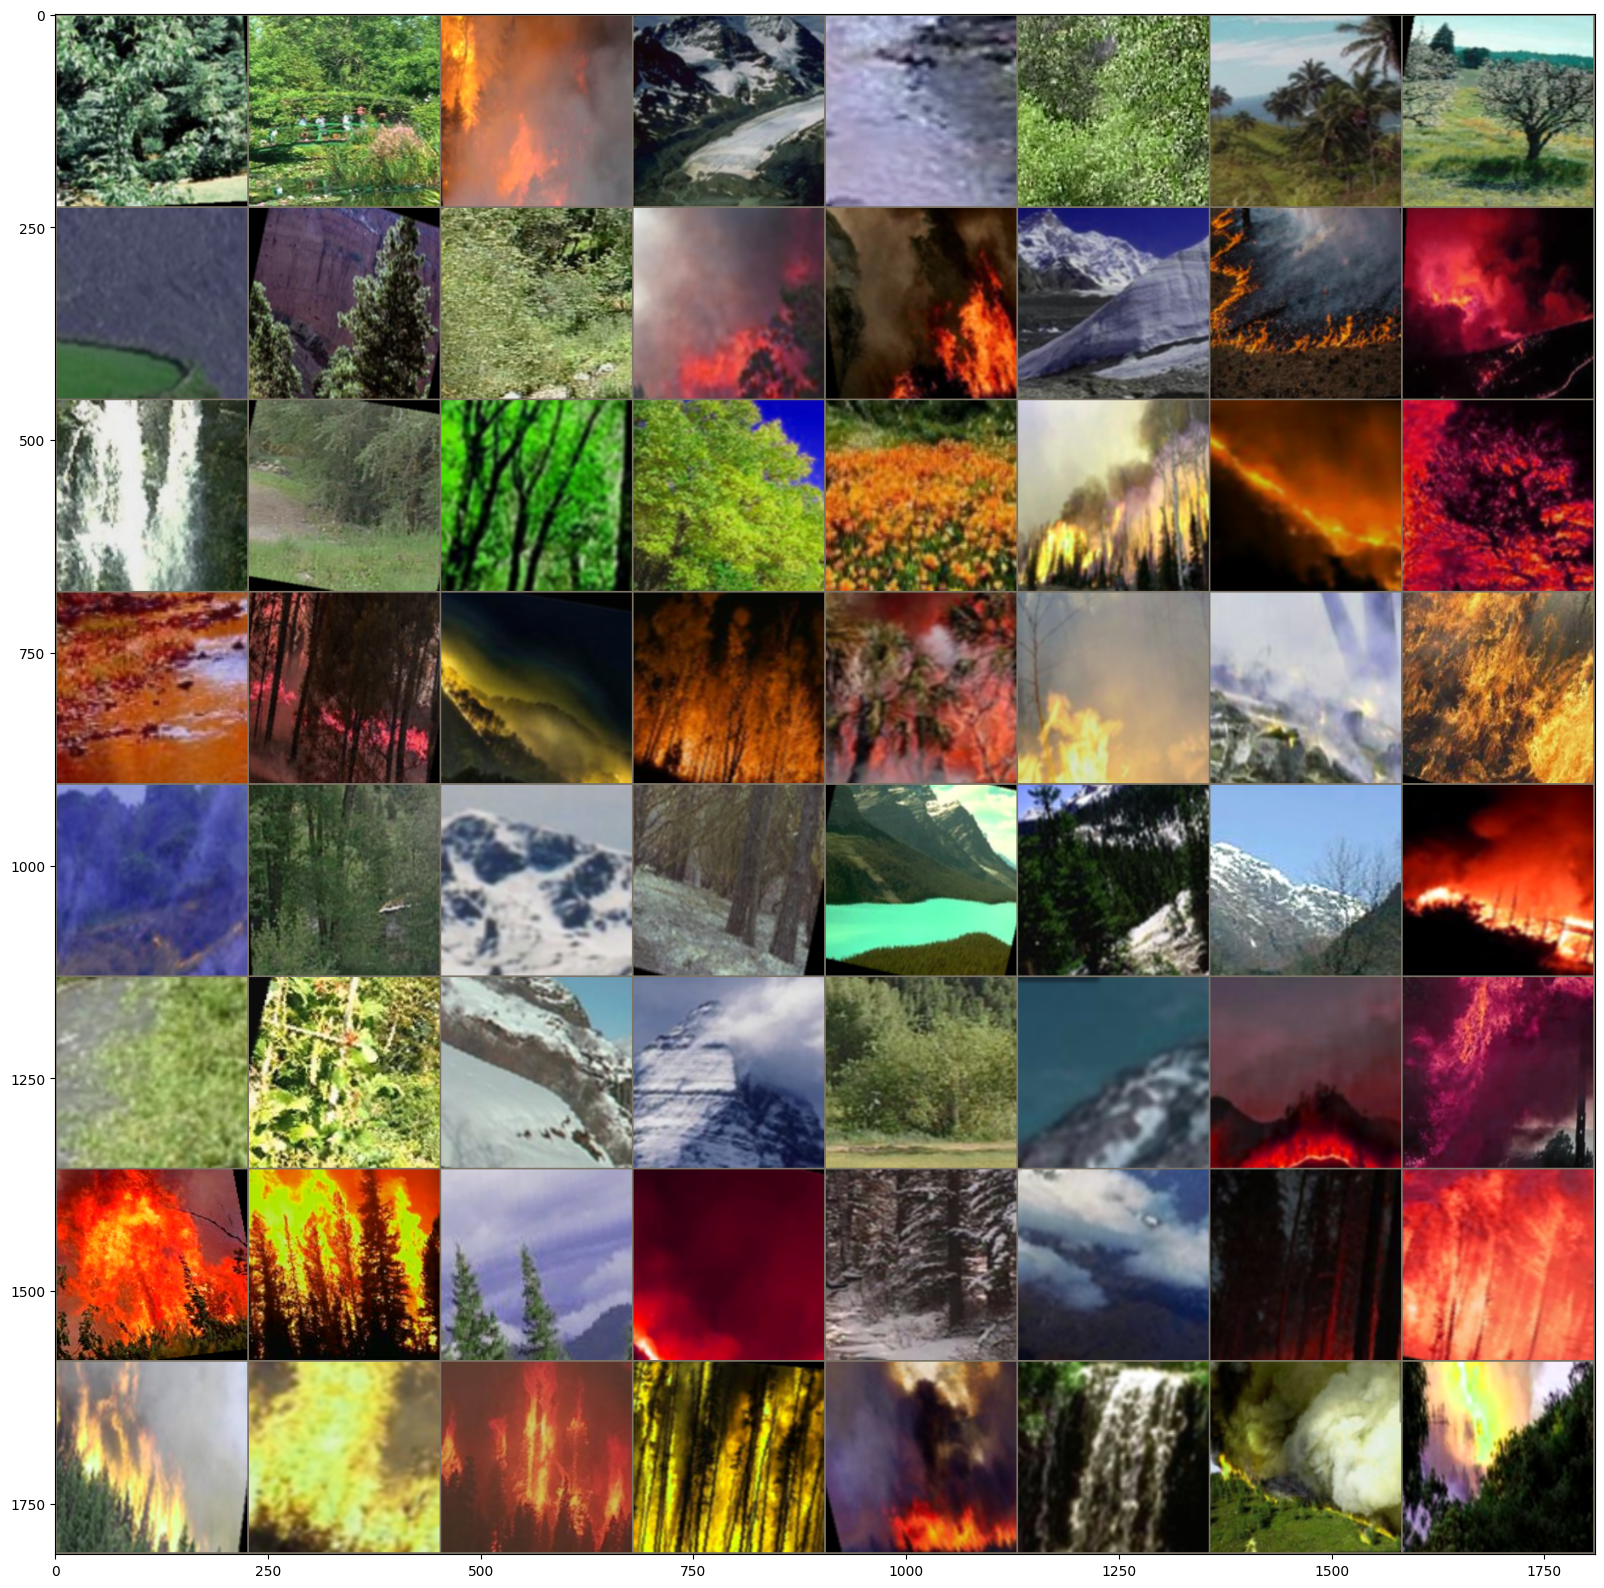

In [ ]:
def show_transformed_image(image):
    # Unnormalize the channels. mageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualize 'batch_size' images
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label, *_ = next(items)

show_transformed_image(utils.make_grid(image))

# Save the image as pdf file.
plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf'))

## A simple CNN architecture
---

* https://pytorch.org/docs/stable/nn.html

In [ ]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:

    Input [3, 224, 224]
    Conv1(3, 6, 5) [6, 220, 220]
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [num_classes]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        ---
        https://pytorch.org/docs/stable/nn.html
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1)
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)

        return x

## Using a pretrainned model (fine-tunning)
---


### Selecting the model

* https://pytorch.org/vision/stable/models.html

In [ ]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    ### model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'efficientnet':  # Pretrained EfficientNet
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')  # Você pode escolher efficientnet_b1, b2, etc.
    num_ftrs = model.classifier[1].in_features  # A última camada do EfficientNet está na posição [1]
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 61.0MB/s]


In [ ]:
# Send the model to the GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Print the model
print(str(model))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Loss function and optimizer

* https://pytorch.org/docs/stable/optim.html

In [ ]:
# Loss function
# https://pytorch.org/docs/stable/nn.html
criterion = nn.CrossEntropyLoss()

# Optimizer
# https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Learning rate scheduler
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

## Training the model
---

In [ ]:
# Total training time (including training and validation).
time_total_start = time.time()

# List of training losses and accuracies for each epoch.
train_loss_list = []
train_acc_list = []

# List of validation losses and accuracies for each epoch.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TRAINING
    # =========================================================================
    # Starts timing the epoch.
    time_epoch_start = time.time()

    # Enables the model for training mode
    model.train()

    # Loss for this epoch.
    loss_epoch_train = 0.0
    # Samples correctly classified in this epoch.
    hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:
        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Enable gradient calculation during training.
        torch.set_grad_enabled(True)

        # -----> FORWARD
        # Model output
        outputs = model(inputs)

        # 'outputs' contains float values. Take the maximum values as the predictions.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss function
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Optimizes the parameters (weights)
        optimizer.step()

        # Updates the epoch loss
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Updates the epoch hits
        hits_epoch_train += torch.sum(preds == labels.data)

    # Training loss and accuracy for this epoch.
    train_loss = loss_epoch_train / train_size
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDATION
    # =========================================================================
    model.eval()

    # Epoch validation loss
    loss_epoch_val = 0.0
    # Num hits for this epoch
    hits_epoch_val = 0

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Disables gradient calculation during validation.
        torch.set_grad_enabled(False)

        # -----> FORWARD
        # Model output
        outputs = model(inputs)

        # Returns the largest prediction.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss
        loss = criterion(outputs, labels)

        # Updates the epoch loss
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Updates the epoch hits
        hits_epoch_val += torch.sum(preds == labels.data)

    # Adjust the learning rate
    scheduler.step()

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)

    # Validation loss and accuracy for this epoch.
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Total time for this epoch
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Total training time
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/49 - TRAIN Loss: 0.7246 TRAIN Acc: 0.4836 - VAL. Loss: 0.7090 VAL. Acc: 0.5014 (324.9604 seconds)
Epoch 1/49 - TRAIN Loss: 0.6917 TRAIN Acc: 0.5574 - VAL. Loss: 0.6716 VAL. Acc: 0.5940 (28.0916 seconds)
Epoch 2/49 - TRAIN Loss: 0.6508 TRAIN Acc: 0.6448 - VAL. Loss: 0.6345 VAL. Acc: 0.6594 (27.6788 seconds)
Epoch 3/49 - TRAIN Loss: 0.6168 TRAIN Acc: 0.7004 - VAL. Loss: 0.5958 VAL. Acc: 0.7684 (27.8863 seconds)
Epoch 4/49 - TRAIN Loss: 0.5866 TRAIN Acc: 0.7732 - VAL. Loss: 0.5784 VAL. Acc: 0.7902 (27.5207 seconds)
Epoch 5/49 - TRAIN Loss: 0.5638 TRAIN Acc: 0.8069 - VAL. Loss: 0.5461 VAL. Acc: 0.8283 (28.1277 seconds)
Epoch 6/49 - TRAIN Loss: 0.5368 TRAIN Acc: 0.8297 - VAL. Loss: 0.5305 VAL. Acc: 0.8610 (27.9415 seconds)
Epoch 7/49 - TRAIN Loss: 0.5168 TRAIN Acc: 0.8588 - VAL. Loss: 0.4871 VAL. Acc: 0.9046 (28.1882 seconds)
Epoch 8/49 - TRAIN Loss: 0.4965 TRAIN Acc: 0.8752 - VAL. Loss: 0.4725 VAL. Acc: 0.9264 (28.1180 seconds)
Epoch 9/49 - TRAIN Loss: 0.4677 TRAIN Acc: 0.8980 - VA

## Saving (and loading) the trained model

In [ ]:
torch.save(model, os.path.join(EXP_PATH, 'model.pth'))

In [ ]:
# Para carregar o modelo
### model = torch.load(os.path.join(EXP_PATH, 'model.pth'))

## Analyzing the training
---

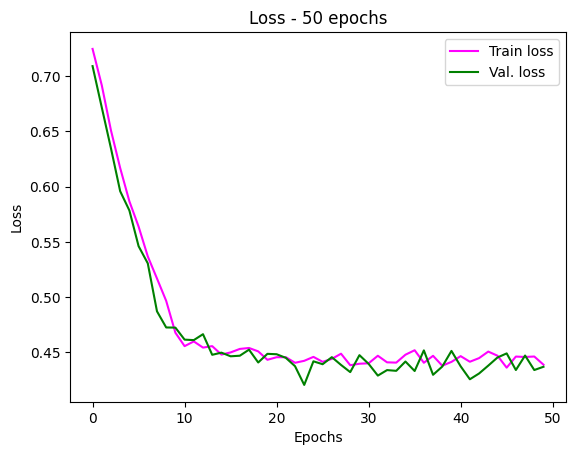

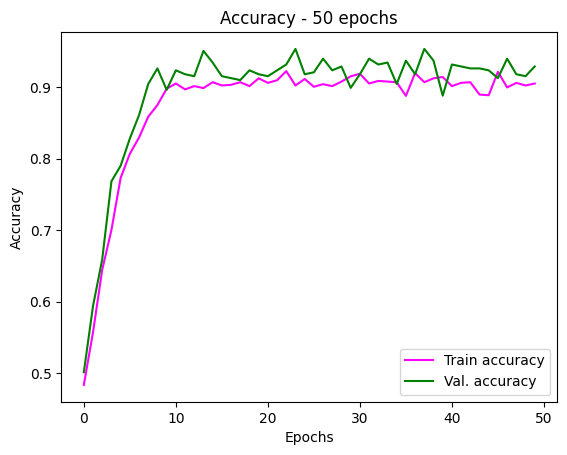

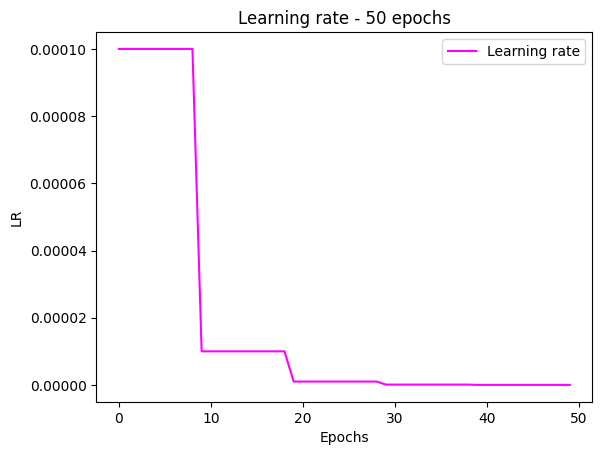

In [ ]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_loss_list)))

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf'))

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf'))

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf'))

## Evaluating the model over the TEST set
---

In [ ]:
# List with true and predicted classes
true_test_list = []
pred_test_list = []
# List with probabilities
prob_test_list = []
# List with the paths to the images
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list, path_list) in enumerate(test_dataloader):

    # Send data to GPU
    img_list = img_list.to(DEVICE)
    label_list = label_list.to(DEVICE)

    # Disables gradient calculation during validation and testing.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Model output
    outputs = model(img_list)

    # Prediction
    preds = torch.argmax(outputs, dim=1)

    # Computes probabilities of each class
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)

    # True classes and predicted classes for this batch.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
        prob_test_batch = list(outputs_prob.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)
        prob_test_batch = list(outputs_prob)

    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch
    prob_test_list += prob_test_batch
    path_test_list += path_list

## Confusion matrix and classification report
---

In [ ]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list,
                                               pred_test_list,
                                               target_names=class_names,
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


Confusion matrix (test set)
[[171  15]
 [ 22 159]]

Class. report (test set)
                 precision    recall  f1-score   support

    fire_images     0.8860    0.9194    0.9024       186
non_fire_images     0.9138    0.8785    0.8958       181

       accuracy                         0.8992       367
      macro avg     0.8999    0.8989    0.8991       367
   weighted avg     0.8997    0.8992    0.8991       367



Validation Acc.: 0.8992


### Saving the classification report (TEST set)

In [ ]:
class_rep_path = os.path.join(EXP_PATH, 'classification_report_test.txt')
file_rep = open(class_rep_path, 'w')

file_rep.write('\nTEST. SET:')
file_rep.write('\n\nConfusion matrix:\n')
file_rep.write(str(conf_mat_test))
file_rep.write('\n\nClassification report:\n')
file_rep.write(class_rep_test)
file_rep.write(f'\n\nAccuracy:\t {acc_test:.4f}')

file_rep.close()

### Detailed classification report (TEST set)

In [ ]:
# Test set
class_rep_path = os.path.join(EXP_PATH, 'class_report_detailed_test.csv')
file_rep = open(class_rep_path, 'w')

print('\n#\tImage path\tTarget\tPrediction\tCorrect?', end='')
file_rep.write('\n#;Image path;Target;Prediction;Correct?')

for class_name in class_names:
    print(f'\t {class_name}', end='')
    file_rep.write(f';{class_name}')

for i, (path, true, pred, probs) in enumerate(zip(path_test_list, true_test_list, pred_test_list, prob_test_list)):
    print(f'\n{i} \t {path} \t {true} \t {pred} \t {true==pred}', end='')
    file_rep.write(f'\n{i};{path};{true};{pred};{true==pred}')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')
        file_rep.write(f';{prob:.4f}')

file_rep.close()


#	Image path	Target	Prediction	Correct?	 fire_images	 non_fire_images
0 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/non_fire_images/nofire_0506.jpg 	 1 	 1 	 True	0.4504	0.5496
1 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/non_fire_images/nofire_0725.jpg 	 1 	 0 	 False	0.5453	0.4547
2 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/non_fire_images/nofire_0235.jpg 	 1 	 1 	 True	0.4394	0.5606
3 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/fire_images/abc162.jpg 	 0 	 0 	 True	0.6527	0.3473
4 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/fire_images/fire_0447.jpg 	 0 	 0 	 True	0.7417	0.2583
5 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/fire_images/fire_0507.jpg 	 0 	 0 	 True	0.7738	0.2262
6 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData/non_fire_images/abc268.jpg 	 1 	 1 	 True	0.4271	0.5729
7 	 /content/drive/MyDrive/Projeto2_visaoComp/Forest_Fire_BigData

## Bibliography
---
* PyTorch. Training a Classifier
    * https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* Microsoft. Train your image classifier model with PyTorch.
    * https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model
* Nathan Inkawhich. FINETUNING TORCHVISION MODELS.
    * (Broken link) https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    * (New link) https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/finetuning_torchvision_models_tutorial.ipynb#scrollTo=kfl9S6PnhsuC
* Sasank Chilamkurthy. TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL.
    * https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Datasets & DataLoaders
    * https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Writing Custom Datasets, DataLoaders and Transforms
    * https://pytorch.org/tutorials/beginner/data_loading_tutorial.html